# Group 1: Project 2


### Title: Predicting Blood Donor Availability with Reliability Guarantees leveraging Split and Mondrian Conformal Prediction

#### Introduction
Blood donation, defined as voluntarily giving blood for healthcare services, saves many lives worldwide. For blood banks, the process of obtaining and sustaining the needed level of blood supply is often complex and demanding of rigorous medical regulations and safety requirements. Notoriously, persistent donor-related challenges such as declining and aging donor population, difficulties in donor recruitment & retention, donor blood type, health, and donor suitability have always been an uphill battle for healthcare systems. In this context, the ability to predict blood donor availability in a sustainable and reliable manner becomes crucial and of practical importance.

As discussed further in the literature review, the availability and participation of donors have been explored through the application of machine learning techniques. Most of the existing literature however, focuses on standard ML predictions which output point predictions or class probabilities, not accounting for uncertainty in a valid and efficient way under finite sampling. This is especially crucial in medical context, where incorrect or overconfident predictions can lead to serious consequences both clinically and operationally. For example, if the blood supply availability is misjudged, there may be a blood shortage putting patients' lives at risk. Therefore, having reliable predictions to plan ahead and efficiently allocate resources for emergency situations is vital.

In response to these challenges, this study utilizes the conformal prediction approach as the framework for uncertainty-aware modeling of blood donor availability, where conformal prediction enables models to communicate uncertainties through set-valued outputs with valid and distribution-free coverage guarantees. From the standpoint of medical management, such function is advantageous where confident predictions can be acted upon more plausibly and ambigous cases can be marked for more conservative planning or further investigation. In greater detail, this project first applies split conformal prediction to logistic regression and random forest models, then further delve into the discussions and interpretations of heterogeneity across blood groups utilising Mondrian conformal prediction, as motivated by the importance of blood group compatibility in transfusion medicine. 


#### Literature Review

A reliable blood supply is a critical component of healthcare delivery, and the prediction of blood donor availability and participation has therefore received considerable attention in healthcare literatures. Among the machine learning approaches most frequently applied in this context are logistic regression and tree-based models, largely due to their interpretability and strong performance on structured data (Kuhn & Johnson, 2013; James et al., 2023). While such models have demonstrated reasonably adequate predictive performance, their outputs in clinical settings are typically limited to point predictions or class probabilities, which often lack explicit quantification of uncertainty. Incorporating uncertainty into predictive outputs can enable healthcare decision-makers to avoid overconfident conclusions and make more informed choices regarding resource allocation and risk mitigation (Ghassemi et al., 2021).

Despite growing emphasis on uncertainty-aware machine learning in healthcare, conformal prediction has only recently gained broader attention in clinical settings, where its primary appeal lies in providing reliable, distribution-free uncertainty estimates (Angelopoulos & Bates, 2021; Ghassemi et al., 2021). Prior work in the blood donation literature has largely focused on point-prediction approaches, with uncertainty typically addressed implicitly through probabilistic classifiers rather than through explicit predictive sets (Kauten et al., 2021; Chideme et al., 2024). In contemporary healthcare applications, however, there is a compelling argument that reliable uncertainty quantification can be regarded as more important than marginal improvements in point-predictive accuracy.

Accordingly, this project focuses on conformal prediction for blood donor availability to demonstrate how uncertainty-aware predictions can provide reliable and interpretable support for decision-making in applied healthcare settings.


#### Data Description

The dataset consists of individual-level blood donor records obtained from a blood donation management system. Each row represents a unique donor and their donation history, blood group, geographic location, and donor availability.

The columns of the dataset include:

- **Behavioral medical features**, including:
  - `months_since_first_donation`: time since the donor’s first recorded donation.
  - `number_of_donation`: total number of past donations.
  - `pints_donated`: cumulative volume of blood donated.
  
  In which they represent proxies for long-term donor enegagement, donor commitment, and donation intensity.

- **Categorical clinical and operational descriptors**, including:
  - `blood_group`: donor's relevant blood type.
  - `city`: geographic location.  
  
  In which they potray certain aspects of transfusion demand and compatibility and potentially regional donation patterns.

- **Outcome variable**:
  - `availability`: binary indicator of whether the donor is currently available to donate.

Personally identifying information (PII) is excluded from the analysis in order to adhere to ethical considerations and to ensure compliance with the General Data Protection Regulation (GDPR) when working with medical-related data of this nature.

The features contained in this dataset reflect common operational and clinical considerations in blood donation activities. This fulfills our motivation on the need to account for heterogeneity across donors and to explicitly communicate uncertainty when predicting donor availability.


####  Research Questions

Based on the characteristics of the dataset and its clinical context, the following research questions sought to be answered:

**RQ1:** Would conformal prediction be able to produce uncertainty-aware blood donor availability predictions reliably in a heterogeneous donor population?

**RQ2:** With emphasis on reliability, how does the model performance vary across donor sample size according to their donation behavioural patterns, geographical context, and blood group?

**RQ3:** Would Mondrian conformal prediction be able to improve subgroup coverage in comparison to global split conformal prediction through group conditional calibration, and what trade-offs in prediction efficiency, if any, are observed?

In conjunction, these research questions would facilitate the evaluation of not only the predicitve performance of blood donor availability, but also the reliability and clinical interpretability of uncertainty-aware models in such settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
import random
import os

np.random.seed(14)
random.seed(14)
os.environ['PYTHONHASHSEED'] = str(14)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


In [2]:
df = pd.read_csv('blood_donor_dataset.csv')

#### Exploratory Data Analysis (EDA)


In [3]:
df.shape

(10000, 12)

In [4]:
df.columns

Index(['donor_id', 'name', 'email', 'password', 'contact_number', 'city',
       'blood_group', 'availability', 'months_since_first_donation',
       'number_of_donation', 'pints_donated', 'created_at'],
      dtype='object')

In [5]:
df.groupby("availability")['donor_id'].count()

availability
No     4915
Yes    5085
Name: donor_id, dtype: int64

We conduct an Exploratory Data Analysis to understand the nature of our data before modeling. To avoid showing personal data, we do not show row values in this section. By inspecting the first rows and the dimension of the data, we familarize ourselves with its overall structure. The blood donor dataset, obtained from Kaggle, consists of 10 000 rows and 12 variables.

 We analyze the distribution of our target variable ```availability```. This variable is binary taking the value of 0 (not available) and 1 (available). The dataset is well balanced with respect to availability: 4 915 observation fall into 'not available' category, and 5085 into 'available' category.

In [6]:
df.isna().sum()

donor_id                       0
name                           0
email                          0
password                       0
contact_number                 0
city                           0
blood_group                    0
availability                   0
months_since_first_donation    0
number_of_donation             0
pints_donated                  0
created_at                     0
dtype: int64

In [7]:
df.describe()

,months_since_first_donation,number_of_donation,pints_donated
count,10000.000000,10000.000000,10000.000000
mean,59.953100,25.128200,37.614000
std,34.911379,14.654195,26.334072
min,0.000000,0.000000,0.000000
25%,30.000000,12.000000,16.000000
50%,60.000000,26.000000,34.000000
75%,90.000000,38.000000,50.000000
max,120.000000,50.000000,100.000000


Next, we inspect the missing values and numerical variables' descriptive statistics. There are no null values in the dataset. We summarize the common statistics such as mean, minimum, maximum, and standard deviation. The statistics differ in their scales and units. For instance, availability is measured as a decimal between 0 and 1, while other units include months, number, and pints. This highlights the importance of correctly preprocesssing our data in the modelling part of the project.

In [8]:
bl_groups = df.groupby('blood_group')['donor_id'].count().reset_index().sort_index()
bl_groups

,blood_group,donor_id
0,A+,1238
1,A-,1236
2,AB+,1219
3,AB-,1284
4,B+,1282
5,B-,1290
6,O+,1240
7,O-,1211


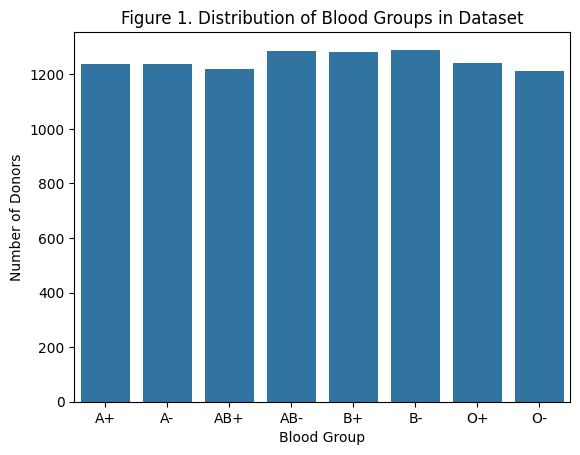

In [9]:
sns.barplot(data=bl_groups, x='blood_group', y='donor_id')
plt.title('Figure 1. Distribution of Blood Groups in Dataset')
plt.xlabel('Blood Group')
plt.ylabel('Number of Donors')
plt.show()

We then analyze the distribution of blood groups. Figure 1 visualizes the distribution using the bar chart. The dataset is almost perfectly balanced across all blood groups, with each group consisting of around 1200-1300 donors. This differs from real-world data, where blood groups are usually imbalanced in nature.

In [10]:
df["availability"] = df["availability"].map({"No": 0, "Yes": 1})

num_cols = [
    'availability',
    'months_since_first_donation',
    'number_of_donation',
    'pints_donated'
]

In [11]:
df[num_cols]

,availability,months_since_first_donation,number_of_donation,pints_donated
0,0,65,31,62
1,1,64,8,16
2,1,39,6,6
3,0,55,20,20
4,0,7,35,35
...,...,...,...,...
9995,1,66,42,42
9996,0,65,14,28
9997,0,57,16,32
9998,1,79,23,46


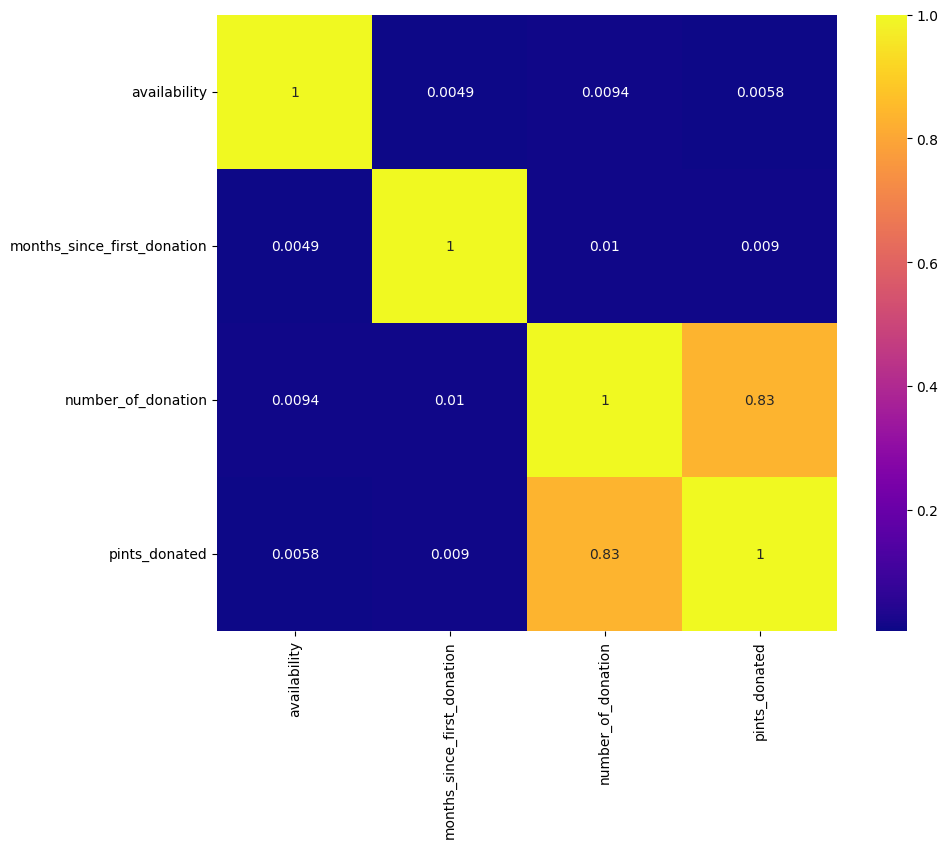

In [12]:
corr = df[num_cols].corr()

f, ax = plt.subplots(figsize=(10, 8))
#mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap = 'plasma', annot=True)
plt.show()

Then we analyze the correlation between the numeric variables in our dataset. There is a high correlation between the number of donations and pints donated (0.83). All three numerical values have low (almost zero) correlation with our target variable ```availability```. This indicates that there is no linear relationship between features and the target, motivating the use of non-linear models. Given the project’s emphasis on reliability guarantees and subgroup coverage, the EDA conducted focused on distribution checks and subgroup compositions. 

#### Modelling 

In [31]:
X = df.drop(columns=["availability"])
y = df["availability"].values

num_features = ["months_since_first_donation", "number_of_donation", "pints_donated"]
cat_features = ["city", "blood_group"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop",
)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size= 0.3, random_state=14, stratify=y)
X_train, X_cal, y_train, y_cal = train_test_split(X_temp, y_temp, test_size=0.3, random_state=14, stratify=y_temp)


log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, random_state=14))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=500,random_state=14,min_samples_leaf=2,n_jobs=-1
    ))
])

X_test.shape

(3000, 11)

In [14]:
log_reg.fit(X_train, y_train)
proba_lr = log_reg.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

accuracy_lr = accuracy_score(y_test, pred_lr)
roc_auc_lr = roc_auc_score(y_test, proba_lr)

rf.fit(X_train, y_train)
proba_rf = rf.predict_proba(X_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

accuracy_rf = accuracy_score(y_test, pred_rf)
roc_auc_rf = roc_auc_score(y_test, proba_rf)

In [15]:
def conformal_qhat(scores, alpha):
    scores = np.asarray(scores)
    n = len(scores)
    k = int(np.ceil((n + 1) * (1 - alpha)))
    k = min(max(k, 1), n)
    return float(np.sort(scores)[k - 1])

log_reg.fit(X_train, y_train)
proba_cal_lr = log_reg.predict_proba(X_cal)
true_prob_cal_lr = proba_cal_lr[np.arange(len(y_cal)), y_cal]
scores_cal_lr = 1 - true_prob_cal_lr
qhat_lr = conformal_qhat(scores_cal_lr, 0.1)

proba_test_lr = log_reg.predict_proba(X_test)
thresh_lr = 1 - qhat_lr

pred_sets_lr = []
for p0, p1 in proba_test_lr:
    s = set()
    if p0 >= thresh_lr: s.add(0)
    if p1 >= thresh_lr: s.add(1)
    pred_sets_lr.append(s)

coverage_lr = np.mean([y_test[i] in pred_sets_lr[i] for i in range(len(y_test))])
avg_size_lr = np.mean([len(s) for s in pred_sets_lr])


rf.fit(X_train, y_train)
proba_cal_rf = rf.predict_proba(X_cal)
true_prob_cal_rf = proba_cal_rf[np.arange(len(y_cal)), y_cal]
scores_cal_rf = 1 - true_prob_cal_rf
qhat_rf = conformal_qhat(scores_cal_rf, 0.1)

proba_test_rf = rf.predict_proba(X_test)
thresh_rf = 1 - qhat_rf

pred_sets_rf = []
for p0, p1 in proba_test_rf:
    s = set()
    if p0 >= thresh_rf: s.add(0)
    if p1 >= thresh_rf: s.add(1)
    pred_sets_rf.append(s)

coverage_rf = np.mean([y_test[i] in pred_sets_rf[i] for i in range(len(y_test))])
avg_size_rf = np.mean([len(s) for s in pred_sets_rf])


In [16]:
test_df = X_test.copy().reset_index(drop=True)
test_df["y_true"] = y_test

test_df["covered_lr"] = [y_test[i] in pred_sets_lr[i] for i in range(len(y_test))]
test_df["set_size_lr"] = [len(s) for s in pred_sets_lr]

by_bg_lr = test_df.groupby("blood_group").agg(
    n=("covered_lr", "size"),
    coverage=("covered_lr", "mean"),
    avg_set_size=("set_size_lr", "mean")
).reset_index().sort_values("coverage")

# Random Forest subgroup
test_df["covered_rf"] = [y_test[i] in pred_sets_rf[i] for i in range(len(y_test))]
test_df["set_size_rf"] = [len(s) for s in pred_sets_rf]

by_bg_rf = test_df.groupby("blood_group").agg(
    n=("covered_rf", "size"),
    coverage=("covered_rf", "mean"),
    avg_set_size=("set_size_rf", "mean")
).reset_index().sort_values("coverage")

In [17]:
rf.fit(X_train, y_train)
proba_cal_rf = rf.predict_proba(X_cal)
true_prob_cal_rf = proba_cal_rf[np.arange(len(y_cal)), y_cal]
scores_cal_rf = 1 - true_prob_cal_rf
qhat_global_rf = conformal_qhat(scores_cal_rf, 0.1)

qhats_bg = {}
for bg in X_cal["blood_group"].unique():
    idx = np.where(X_cal["blood_group"].values == bg)[0]
    true_probs_bg = proba_cal_rf[idx, y_cal[idx]]
    scores_bg = 1 - true_probs_bg
    qhats_bg[bg] = conformal_qhat(scores_bg, 0.1)

proba_test_rf = rf.predict_proba(X_test)
pred_sets_m_bg = []

for i in range(len(X_test)):
    bg = X_test.iloc[i]["blood_group"]
    qhat = qhats_bg.get(bg, qhat_global_rf)
    thresh = 1 - qhat
    p0, p1 = proba_test_rf[i]
    s = set()
    if p0 >= thresh: s.add(0)
    if p1 >= thresh: s.add(1)
    pred_sets_m_bg.append(s)

coverage_m_bg = np.mean([y_test[i] in pred_sets_m_bg[i] for i in range(len(y_test))])
avg_size_m_bg = np.mean([len(s) for s in pred_sets_m_bg])


mondrian_bg_df = test_df.copy()
mondrian_bg_df["covered_m_bg"] = [y_test[i] in pred_sets_m_bg[i] for i in range(len(y_test))]
mondrian_bg_df["set_size_m_bg"] = [len(s) for s in pred_sets_m_bg]

by_bg_m = mondrian_bg_df.groupby("blood_group").agg(
    n=("covered_m_bg", "size"),
    coverage=("covered_m_bg", "mean"),
    avg_set_size=("set_size_m_bg", "mean")
).reset_index().sort_values("coverage")

To start the modelling process, we encode the designated target variable, donor availability, with the typical binary encoding where “Yes” is 1 and 0 proxies “No”. As for the features, we have a combination of numerical and categorical variables, including months since first donation, number of donations, total pints donated, donor location, and blood group.

As we will be implementing a logistic regression model shortly, it is important that we standardize the mentioned numerical attributes to zero mean and unit variance. Further, the categorical variables were encoded using one-hot encoding, with additional support for latent categories at inference. All other variables were dropped to avoid leakage.

Subsequently, the dataset was partitioned into three subsets: a training set for model learning, a calibration set for conformal prediction calibration, and a held-out test set for model evaluation. We ensured that stratified sampling was applied to preserve class balance. Such separation also ensures that validity holds for conformal prediction coverage guarantees.

Following that, a logistic regression model and a random forest were fitted to the data. Logistic regression serves the purpose of a transparent and interpretable linear baseline, while the random forest model functions to capture nonlinear interactions and latent structures. Both models used identical preprocessing pipelines, as mentioned above.

Coming to the project objective, both models were wrapped with split conformal prediction to construct uncertainty-aware prediction intervals with a target coverage guarantee of 90% (alpha = 0.1). The calibration set was utilized to calculate nonconformity scores using one minus the predicted probability assigned to the true class. The resulting quantile threshold (q_hat) was then employed to generate set-valued predictions on the test set. Additionally, to assess the reliability and efficiency of the developed prediction sets, average prediction set size and empirical coverage were also computed.

Next, the empirical coverage and prediction set size were analysed by blood group to evaluate reliability across clinically and operationally meaningful subpopulations. In this way, we could focus on and inspect potential latent disparities in uncertainty calibration, if any. This part will be further discussed in the Results and Discussion section.

Lastly, Mondrian conformal prediction was introduced, leveraging blood group as the conditioning variable to address subgroup-level variability. The calibration set was again used, this time to estimate group-specific calibration thresholds, alongside a global threshold used as a fallback for latent categories. As such, an assessment of trade-offs between prediction efficiency and subgroup reliability can be carried out.


#### Results and Discussion

In [18]:
print("=" * 19)
print("Logistic Regression")
print("=" * 19)
print(f"Accuracy: {accuracy_lr:.3f}")
print(f"ROC-AUC: {roc_auc_lr:.3f}")
print("\nClassification report:")
print(classification_report(y_test, pred_lr))

print("=" * 13)
print("Random Forest")
print("=" * 13)
print(f"Accuracy: {accuracy_rf:.3f}")
print(f"ROC-AUC: {roc_auc_rf:.3f}")
print("\nClassification report:")
print(classification_report(y_test, pred_rf))

Logistic Regression
Accuracy: 0.496
ROC-AUC: 0.498

Classification report:
              precision    recall  f1-score   support

           0       0.48      0.35      0.40      1474
           1       0.50      0.64      0.56      1526

    accuracy                           0.50      3000
   macro avg       0.49      0.49      0.48      3000
weighted avg       0.49      0.50      0.48      3000

Random Forest
Accuracy: 0.491
ROC-AUC: 0.494

Classification report:
              precision    recall  f1-score   support

           0       0.48      0.46      0.47      1474
           1       0.50      0.52      0.51      1526

    accuracy                           0.49      3000
   macro avg       0.49      0.49      0.49      3000
weighted avg       0.49      0.49      0.49      3000



In [19]:
X_city = df[["city"]].copy()

X_temp_c, X_test_c, y_temp_c, y_test_c = train_test_split(X_city, y, test_size=0.3, random_state=14, stratify=y)
X_train_c, X_cal_c, y_train_c, y_cal_c = train_test_split(X_temp_c, y_temp_c, test_size=0.3, random_state=14, stratify=y_temp_c)

preprocess_city = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), ["city"])],remainder="drop")

city_only_lr = Pipeline(steps=[("prep", preprocess_city),("clf", LogisticRegression(max_iter=2000, random_state=14))])

city_only_lr.fit(X_train_c, y_train_c)
proba_city = city_only_lr.predict_proba(X_test_c)[:, 1]
pred_city = (proba_city >= 0.5).astype(int)

acc_city = accuracy_score(y_test_c, pred_city)
auc_city = roc_auc_score(y_test_c, proba_city)
print()
print("=" * 29)
print("City-only Logistic Regression")
print("=" * 29)
print(f"Accuracy: {acc_city:.3f}")
print(f"ROC-AUC: {auc_city:.3f}")



City-only Logistic Regression
Accuracy: 0.509
ROC-AUC: 0.505


Evidently, both models display limited discriminative performance, with ROC–AUC values close to 0.5, suggesting near-random classification ability. Given the more or less balanced class distribution of the target, blood donor availability appears inherently difficult to predict using the available predictors alone, rather than being an artefact of model choice (covering both linear and nonlinear effects) or class imbalance.

To confirm the claim above, an additional diagnostic check is carried out where a city-as-the-only-feature logistic regression model was evaluated. While its accuracy and ROC-AUC achieved marginally higher scores, the discriminative powers of it remains indistinguisable from random guessing. Taken together, these results indicate that the limited performance arises from informational constraints of the dataset itself and not inadequate modeling choices. Rather than attempting to optimize point-predictive accuracy, this properly motivates the use of uncertainty-aware methods to quantify predictive reliability, particularly under conditions of weak signal.


In [20]:
print("=" * 36)
print("Split Conformal: Logistic Regression")
print("=" * 36)
print(f"Alpha (miscoverage): {0.1}")
print(f"Target coverage: {1 - 0.1:.3f}")
print(f"Empirical coverage: {coverage_lr:.3f}")
print(f"Average prediction set size: {avg_size_lr:.3f}")
print(f"q-hat: {qhat_lr:.3f}")
print("\nPrediction set size distribution:")
print(pd.Series([len(s) for s in pred_sets_lr]).value_counts().sort_index())

print()
print("=" * 30)
print("Split Conformal: Random Forest")
print("=" * 30)
print(f"Alpha (miscoverage): {0.1}")
print(f"Target coverage: {1 - 0.1:.3f}")
print(f"Empirical coverage: {coverage_rf:.3f}")
print(f"Average prediction set size: {avg_size_rf:.3f}")
print(f"q-hat: {qhat_rf:.3f}")
print("\nPrediction set size distribution:")
print(pd.Series([len(s) for s in pred_sets_rf]).value_counts().sort_index())
print()

print("=" * 34)
print("Split Conformal Summary Comparison")
print("=" * 34)
print(f"Logistic Regression | coverage: {coverage_lr:.3f}, avg set size: {avg_size_lr:.3f}")
print(f"Random Forest       | coverage: {coverage_rf:.3f}, avg set size: {avg_size_rf:.3f}")

Split Conformal: Logistic Regression
Alpha (miscoverage): 0.1
Target coverage: 0.900
Empirical coverage: 0.888
Average prediction set size: 1.777
q-hat: 0.532

Prediction set size distribution:
1     668
2    2332
Name: count, dtype: int64

Split Conformal: Random Forest
Alpha (miscoverage): 0.1
Target coverage: 0.900
Empirical coverage: 0.905
Average prediction set size: 1.810
q-hat: 0.670

Prediction set size distribution:
1     569
2    2431
Name: count, dtype: int64

Split Conformal Summary Comparison
Logistic Regression | coverage: 0.888, avg set size: 1.777
Random Forest       | coverage: 0.905, avg set size: 1.810


For the split conformal prediction–wrapped logistic regression model, empirical coverage reached approximately 0.888, slightly below the set nominal target of 90% coverage. It attained an average prediction set size of 1.777, suggesting that most point predictions required uncertainty-aware sets containing both classes rather than confident singleton predictions. Looking at the prediction set size distribution, indeed the majority of instances were assigned prediction sets of size two (2332 versus 668 singleton sets), which solidifies the claim of substantial uncertainty in the underlying predictions.

On the other hand, for the random forest model, empirical coverage reached 0.905, which satisfies the set nominal target level of 0.9. However, the average prediction set size was comparatively larger at approximately 1.810, indicating an even higher proportion of size-two prediction sets (2431 versus 569 singleton sets). From this, it can be inferred that the split conformal prediction–wrapped random forest model achieves nominal coverage by expressing uncertainty in a marginally more conservative manner.

Altogether, both models managed to achieve empirical coverage close to the nominal target with α = 0.1 despite their limited discriminative abilities. Again, the predominance of size-two prediction sets highlights the complexity of using the available feature set to generate reliable inference on blood donor availability and further emphasizes the value of uncertainty-aware outputs in such settings. The benefit of providing a more reliable basis through explicitly communicated predictive uncertainty, rather than forcing overconfident decisions, is reflected here and will be discussed further below. 

In [21]:
print("=" * 62)
print("Split Conformal: Logistic Regression — Coverage by Blood Group")
print("=" * 62)
for _, row in by_bg_lr.sort_values("coverage").iterrows():
    print(
        f"Blood group {row['blood_group']:>3} | "f"n={int(row['n']):4d} | " f"coverage={row['coverage']:.3f} | " f"avg set size={row['avg_set_size']:.3f}"
    )
print()
print("=" * 56)
print("Split Conformal: Random Forest — Coverage by Blood Group")
print("=" * 56)
for _, row in by_bg_rf.sort_values("coverage").iterrows():
    print(
        f"Blood group {row['blood_group']:>3} | "f"n={int(row['n']):4d} | "f"coverage={row['coverage']:.3f} | "f"avg set size={row['avg_set_size']:.3f}"
    )

Split Conformal: Logistic Regression — Coverage by Blood Group
Blood group  A- | n= 370 | coverage=0.786 | avg set size=1.589
Blood group  O+ | n= 385 | coverage=0.795 | avg set size=1.522
Blood group  B- | n= 400 | coverage=0.812 | avg set size=1.635
Blood group AB- | n= 374 | coverage=0.898 | avg set size=1.818
Blood group AB+ | n= 378 | coverage=0.926 | avg set size=1.884
Blood group  A+ | n= 352 | coverage=0.966 | avg set size=1.932
Blood group  B+ | n= 382 | coverage=0.966 | avg set size=1.935
Blood group  O- | n= 359 | coverage=0.967 | avg set size=1.930

Split Conformal: Random Forest — Coverage by Blood Group
Blood group  O- | n= 359 | coverage=0.880 | avg set size=1.774
Blood group AB- | n= 374 | coverage=0.885 | avg set size=1.781
Blood group AB+ | n= 378 | coverage=0.899 | avg set size=1.817
Blood group  B+ | n= 382 | coverage=0.906 | avg set size=1.825
Blood group  B- | n= 400 | coverage=0.907 | avg set size=1.802
Blood group  A+ | n= 352 | coverage=0.915 | avg set size=1.8

The subgroup summaries for both the logistic regression and random forest models reveal considerable variability in empirical coverage across blood groups under split conformal prediction. For the logistic regression model, notable undercoverage is observed for several subgroups: in particular, A− and O+ donors exhibit empirical coverage below 0.80, well under the nominal target of 0.90. This indicates that a single global conformal threshold fails to provide uniform validity across clinically meaningful blood-group subpopulations. In contrast, blood groups such as O−, B+, and A+ exceed the nominal coverage level, albeit at the cost of noticeably larger average prediction set sizes, reflecting increased uncertainty.

The random forest model demonstrates improved overall behavior relative to logistic regression, with subgroup coverage levels generally closer to the target coverage of alpha = 0.1. Nevertheless, notable deviations persist, with O− and AB− still exhibiting substandard empirical coverage. These findings suggest that while increased model flexibility can mitigate some sources of variability, global split conformal calibration remains insufficient to ensure reliable coverage guarantees at the subgroup level.

Taken together, these results highlight the inherent limitation of marginally valid conformal methods in heterogeneous populations and motivate the adoption of group-conditional approaches, such as Mondrian conformal prediction, which will be discussed in the following subsection.

Mondrian Conformal (Blood Group): Random Forest
Alpha (miscoverage): 0.1
Target coverage: 0.900
Empirical coverage : 0.905
Average prediction set size: 1.808
Global fallback q-hat: 0.670

Group-specific q-hat values (blood group -> q-hat):
 A+ -> 0.667
 A- -> 0.655
AB+ -> 0.681
AB- -> 0.647
 B+ -> 0.681
 B- -> 0.669
 O+ -> 0.684
 O- -> 0.684

Prediction set size distribution:
1     575
2    2425
Name: count, dtype: int64

Mondrian Conformal: Random Forest — Coverage by Blood Group
Blood group AB- | n= 374 | coverage=0.840 | avg set size=1.698
Blood group  B- | n= 400 | coverage=0.902 | avg set size=1.798
Blood group  A+ | n= 352 | coverage=0.906 | avg set size=1.801
Blood group  O- | n= 359 | coverage=0.911 | avg set size=1.813
Blood group  A- | n= 370 | coverage=0.914 | avg set size=1.784
Blood group  B+ | n= 382 | coverage=0.919 | avg set size=1.843
Blood group AB+ | n= 378 | coverage=0.921 | avg set size=1.862
Blood group  O+ | n= 385 | coverage=0.925 | avg set size=1.865

Calibrati

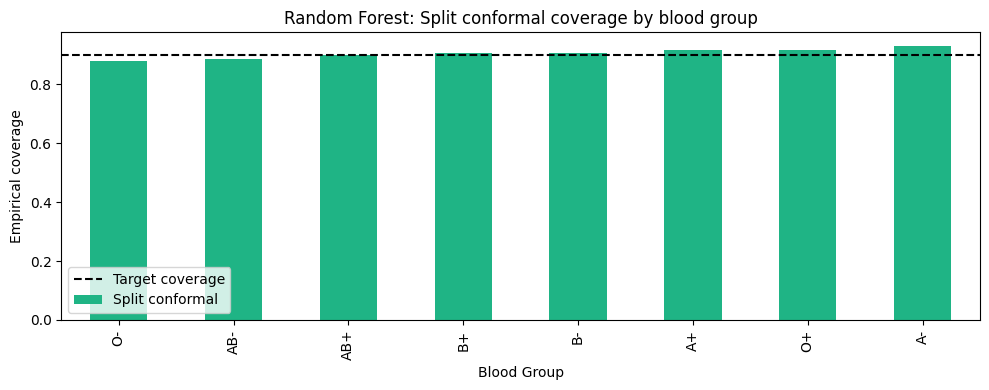

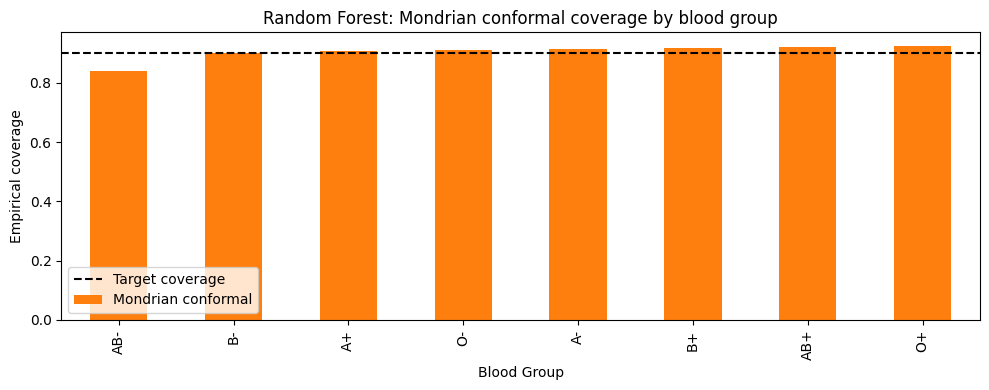

In [22]:
print("=" * 47)
print("Mondrian Conformal (Blood Group): Random Forest")
print("=" * 47)
print(f"Alpha (miscoverage): {0.1}")
print(f"Target coverage: {1 - 0.1:.3f}")
print(f"Empirical coverage : {coverage_m_bg:.3f}")
print(f"Average prediction set size: {avg_size_m_bg:.3f}")
print(f"Global fallback q-hat: {qhat_global_rf:.3f}")

print("\nGroup-specific q-hat values (blood group -> q-hat):")
for bg in sorted(qhats_bg.keys()):
    print(f"{bg:>3} -> {qhats_bg[bg]:.3f}")

print("\nPrediction set size distribution:")
print(pd.Series([len(s) for s in pred_sets_m_bg]).value_counts().sort_index())
print()
print("=" * 59)
print("Mondrian Conformal: Random Forest — Coverage by Blood Group")
print("=" * 59)
for _, row in by_bg_m.sort_values("coverage").iterrows():
    print(
        f"Blood group {row['blood_group']:>3} | "f"n={int(row['n']):4d} | "f"coverage={row['coverage']:.3f} | "f"avg set size={row['avg_set_size']:.3f}"
    )

print("\nCalibration sample sizes by blood group:")
cal_counts = (
    X_cal["blood_group"]
    .value_counts()
    .sort_index()
)

for bg, n_cal in cal_counts.items():
    print(f"{bg:>3} | n_cal={n_cal}")

plt.figure(figsize=(10, 4))
by_bg_rf.set_index("blood_group")["coverage"].plot(
    kind="bar", color="#1fb485", label="Split conformal"
)
plt.axhline(1 - 0.1, linestyle="--", color="black", label="Target coverage")
plt.ylabel("Empirical coverage")
plt.xlabel("Blood Group")
plt.title("Random Forest: Split conformal coverage by blood group")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
by_bg_m.set_index("blood_group")["coverage"].plot(
    kind="bar", color="#ff7f0e", label="Mondrian conformal"
)
plt.axhline(1 - 0.1, linestyle="--", color="black", label="Target coverage")
plt.ylabel("Empirical coverage")
plt.xlabel("Blood Group")
plt.title("Random Forest: Mondrian conformal coverage by blood group")
plt.legend()
plt.tight_layout()
plt.show()

As elaborated above, Mondrian conformal prediction was applied, again using blood group as the conditioning variable on the random forest model, to facilitate comparisons between global calibration thresholds and group-specific thresholds. First, Mondrian conformal prediction attains an empirical coverage of 0.905, which aligns closely with the nominal target of 90% coverage, while achieving an average prediction set size that does not deviate substantially from that of the split conformal calibration applied to the random forest model. At the subgroup level, however, coverage is evidently more balanced across blood groups, with most blood groups achieving coverage at or above the target level, and AB− being the sole exception with an empirical coverage of 0.84 (which is suspected again due to behavioral factors unobserved by the available features, as shown by the balance in calibration sample sizes that it is not due to finite-sample noise). These results suggest that group-conditional calibration does indeed mitigate subgroup reliability dispersion. Moreover, only mild variations are observed in the average prediction set sizes across blood groups, indicating a favorable trade-off between validity and efficiency.

Overall, these results provide strong affirmation that Mondrian conformal prediction meaningfully elevates subgroup-level reliability in the task of predicting blood donor availability.

An unsung yet crucial aspect of predictive modelling is highlighted by this project: when the underlying signal is uncertain, marginal improvements in point-prediction accuracy should not be prioritised; instead, the focal point should be on enhancing the ability to reliably communicate uncertainty.

For both baseline models, point-prediction performance in terms of ROC–AUC and accuracy is only marginally better than random guessing. This outcome is not surprising, as donor availability is influenced by a substantially wide range of factors that are not captured in the available dataset, such as external commitments, temporal constraints, and personal health conditions. Under such circumstances, forcing deterministic patterns to be learned often leads to potentially misleading outputs and manifestations of overconfidence.

Conformal prediction serves as an appropriate remedy in this context, as it emphasises a shift in focus from what the model predicts to how reliable those predictions are. Split conformal prediction was first applied to achieve near-target coverage at the population level, followed by Mondrian conformal prediction to further close the gap by attaining more precise and cautious subgroup coverage without incurring meaningful increases in prediction set size. In practice, the latter approach strengthens the results by replacing false precision with more transparent expressions of uncertainty for blood-group-specific subpopulations.

From an operational viewpoint of blood donation management, these discoveries yield direct implications. A non-singleton prediction set ({'available', 'not available'}) should convert to a signal to trigger conservative actions and deference from automated decisions, such as setting up backup donor recruitment campaigns and increased buffer planning. Inversely, singleton predictions can be spotlit for efficient reminder lalocation or routine scheduling.

For non-technical stakeholders within the healthcare domain, namely policy planners, blood bank managers, and administrators, the distinction emphasised in this project is of material importance. A system that outputs an “uncertain” prediction does not represent a failed deployment; rather, it provides concrete and actionable information that supports safer and more robust healthcare decision-making. In settings where the cost of being wrong often outweighs the benefit of being confidently right, conformal prediction offers a principled framework for decision support in blood donation management.

#### Limitations

Several limitations of this project should be made aware when intepreting the results. 

First and foremost, as noted the predicitve capabilities of the baseline models were subpar at best, with both random forest and logisitic regression showcasing ROC-AUC values of slightly under 0.5. As previously inferred, the dataset lacks signals that are likely to be important drivers of donor availabilility in crucial real-world settings. Richer temporal, behavioural and contextual information were lacking. 

Next, the dataset is from Kaggle where it was published with limited documentation regarding its data collection procedures and label construction. Therefore, we should not rule out the possibility of selection bias or noise in general for safety precautions. This might also partially explain the limitedness of discrminative features observed. 

Following that, while the Mondrian conformal prediction implemented increased the subgroup-level reliability in its outcome, one blood group (AB) still did not reach the nominal coverage. When subgroup sizes are limited, this reflects the inherent trade-off between validity and efficiency, which might also limit the generalizability of the findings to operational blood donar systems. 

Lastly, this study also focused on binary classification of blood donor availability and conformal prediction set sizes as the primary source-of-representation for uncertainty and implicitly assumes temporal stability between the training, calibration, and test sets. In practice, blood donation behaviour is subject to temporal shifts driven by external events such as seasonal demand, policy changes, and public health campaigns. That is to say the fundamental exchangeability assumption underlying conformal prediction may potentially be violated if the data-generating process changes over time, which would weaken the reliability guarantees when deployed prospectively. In future scopes, althernative uncertainy-aware approaches such as temporal-dependent models or sequential decision frameworks might be better suited to capture the dynamic nature of blood donor availability. 

That being said, this study has demonstrated that uncertainty-aware methods are capable of providing grounded reliability guarantees even in low-signal healthcare prediction taks to properly support interpretable decision making.

#### Conclusion

The conducted study goes beyond standard classification by combining point-prediction machine learning models (Logistic Regression, Random Forest) with Conformal Prediction to achieve coverage guarantees under finite sampling. We conducted an exploratory data analysis, reviewed relevant literature and extended the research area by jointly reporting both conventional predictive performance and uncertainty-based results under global and sub-group conditional settings.

In summary, while point accuracy-based performance metrics showed similar discriminaive power no better than a random guess, such outcome reflects more of the latent and partially unobserved determinants of blood donor availability inherited from the dataset rather than a deficiency in the modelling approach. In such low-signal settings, it would be more convincing and of-importance to have predictive uncertainty communicated in a transparent and reliable way. The findings therefore underscores the practical relevance of conformal prediction as a decision-support framework in healthcare contexts, for which uncertainty is intrinsic and the cost of overconfident decisions is high. Not only does it enable safer and more cautious planning strategies, it also showcases that uncertainty is not a systematic weakness but an informative output that would guide risk-ware decision-mkaing.

With the results obtained and illustrated above, uncertainty-aware methods are shown to provide grounded and interpretable reliability guarantees in blood donation management. For policy planners, blood bank managers, and healthcare administrators, such guarantees can translate into actionable insights for contingency planning, prioritisation, and resource allocation, feasibly leading to better outcomes within a more robust blood donation management environment.

#### References
Angelopoulos, A. N., & Bates, S. (2021).  
A gentle introduction to conformal prediction and distribution-free uncertainty quantification.  
*arXiv preprint arXiv:2107.07511*. https://arxiv.org/abs/2107.07511

Aljohani, A., Khan, A., & Zhang, L. (2024). A comparative analysis of clustering algorithms for electronic health records: Patient stratification and insights for personalized care. *Journal of Healthcare Informatics Research, 8*(1), 1–18. https://doi.org/10.1007/s44196-024-00568-8

Chideme, M., Mburu, J., & Mwai, D. (2024).  
Predicting voluntary blood donation behavior using machine learning techniques.  
*BMC Medical Informatics and Decision Making, 24*, Article 42. https://doi.org/10.1186/s12911-024-02458-7

Kauten, R., Ziemann, M., & Schmidt, A. (2021).  
Machine learning models for predicting blood donor return behavior.  
*Transfusion Medicine and Hemotherapy, 48*(5), 329–338. https://doi.org/10.1159/000515432

Momahhed, S. S., Jafari, M., & Gerayeli, D. (2023). K-means clustering of outpatient prescription claims for health insureds: Demographic and behavioral segmentation. *BMC Public Health, 23*, 15753. https://doi.org/10.1186/s12889-023-15753-1 

Ghassemi, M., Oakden-Rayner, L., & Beam, A. L. (2021).  
The false hope of current approaches to explainable artificial intelligence in health care.  
*The Lancet Digital Health, 3*(11), e745–e750. https://doi.org/10.1016/S2589-7500(21)00208-9

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2023).  
*An introduction to statistical learning: With applications in Python* (2nd ed.).  
Springer. https://doi.org/10.1007/978-3-031-38747-0

Kuhn, M., & Johnson, K. (2013).  
*Applied predictive modeling*.  
Springer. https://doi.org/10.1007/978-1-4614-6849-3

Vovk, V., Gammerman, A., & Shafer, G. (2005).  
*Algorithmic learning in a random world*.  
Springer. https://doi.org/10.1007/b106715




